In [1]:
import torch
import torch.nn as nn
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from datasets import load_dataset, load_metric
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix

### Load Dataset and intialise parameters

In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
dataset = load_dataset("surrey-nlp/PLOD-CW")
# Vocab dictionary
word_index = {}
# Model parameters
embedding_dim = 300
hidden_dim = 128

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Data Pre-processing (Remove punctuation and stand alone numbers)
* Leave only alphanumeric characters

In [4]:
def remove_punctuation(dataset):
    # To remove punctuations and replace with empty string
    punctuation_re = re.compile(r'[^\w\s]')
    dataset['tokens'] = [punctuation_re.sub('', token) for token in dataset['tokens']]
    return dataset

def remove_numeric_string(dataset):
    # To remove numbers and replace with empty string
    numeric_re = re.compile(r'\b\d+\b')
    dataset['tokens'] = [numeric_re.sub('', token) for token in dataset['tokens']]
    return dataset

def remove_empty_tokens(dataset):
    new_tokens, new_pos_tags, new_ner_tags = [], [], []

    for tokens, pos_tags, ner_tags in zip(dataset['tokens'], dataset['pos_tags'], dataset['ner_tags']):
        temp_tokens, temp_pos, temp_ner = [], [], []

        # To remove empty stings and corresponding ner_tags and pos_tags
        for i in range(len(tokens)):
            if tokens[i] != '':
                temp_tokens.append(tokens[i])
                temp_pos.append(pos_tags[i])
                temp_ner.append(ner_tags[i])
        if temp_tokens:
            new_tokens.append(temp_tokens)
            new_pos_tags.append(temp_pos)
            new_ner_tags.append(temp_ner)

    return {'tokens': new_tokens, 'pos_tags': new_pos_tags, 'ner_tags': new_ner_tags}


### Apply data pre-processing changes

In [5]:
dataset = dataset.map(lambda dataset: remove_punctuation(dataset))
dataset = dataset.map(lambda dataset: remove_numeric_string(dataset))

dataset['train'] = dataset['train'].map(remove_empty_tokens, batched=True)
dataset['validation'] = dataset['validation'].map(remove_empty_tokens, batched=True)
dataset['test'] = dataset['test'].map(remove_empty_tokens, batched=True)

In [6]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [7]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

In [8]:
# Encode the tag (one hot encoding)
def encode_label(tags):
    return [label_encoding[tag] for tag in tags]

# Build a corpus dictionary with unique ID for each word
def build_vocab(dataset):
    global  word_index
    for item in dataset['tokens']:
        for word in item:
            if word not in word_index:
                word_index[word] = len(word_index)
    return word_index

In [9]:
word_index = build_vocab(train_dataset)
word_index = build_vocab(val_dataset)
word_index = build_vocab(test_dataset)

### Define the LSTM model

In [10]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tags):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_dim, tags)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = self.fc(lstm_out)
        return torch.log_softmax(lstm_out, dim=-1)

In [11]:
# Encode strings amd return tensor
def encode_sequence(seq, encoder=None):
    if not seq:
        return torch.tensor(encoded_ids, dtype=torch.long)
    if type(seq[0]) == int:
        encoded_ids = seq
    else:
        encoded_ids = [encoder[word] for word in seq]
    return torch.tensor(encoded_ids, dtype=torch.long)

In [12]:
# Evaluate the model
def evaluate(model, token_dataset, word_index):
    global label_encoding
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, datapoint in enumerate(token_dataset):
            inputs = encode_sequence(datapoint['tokens'], word_index)
            targets = encode_sequence(encode_label(datapoint['ner_tags']))
            tag_scores = model(inputs.unsqueeze(0))

            predicted_tags = tag_scores.max(-1)[1].squeeze().tolist()
            # print(predicted_tags)
            if type(predicted_tags) != list: predicted_tags = [predicted_tags]
            y_pred.extend(predicted_tags)
            y_true.extend(targets.tolist())

    # Detailed performance metrics
    labels_indices = list(label_encoding.values())
    labels_names = list(label_encoding.keys())
    print(classification_report(y_true, y_pred, labels=labels_indices, target_names=labels_names))

    overall_f1 = f1_score(y_true, y_pred, average= 'macro')
    overall_precision = precision_score(y_true, y_pred, average='macro')
    overall_recall = recall_score(y_true, y_pred, average='macro')
    print(f'Overall F1 Score: {overall_f1}')
    print(f'Overall Precision Score: {overall_precision}')
    print(f'Overall Recall Score: {overall_recall}')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[labels_indices])
    disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_names, yticklabels=labels_names) # adjust cmap if needed
    disp.set_xlabel("Predicted Label")
    disp.set_ylabel("True Label")
    disp.set_title("Confusion Matrix for NER-tags")
    plt.show()

### Training and Evaluation

              precision    recall  f1-score   support

         B-O       0.87      0.95      0.91      3037
        B-AC       0.54      0.30      0.38       269
        B-LF       0.29      0.22      0.25       149
        I-LF       0.48      0.29      0.36       259

    accuracy                           0.82      3714
   macro avg       0.55      0.44      0.48      3714
weighted avg       0.80      0.82      0.80      3714

Overall F1 Score: 0.47519206361867644
Overall Precision Score: 0.5464942171883417
Overall Recall Score: 0.43740002245722887


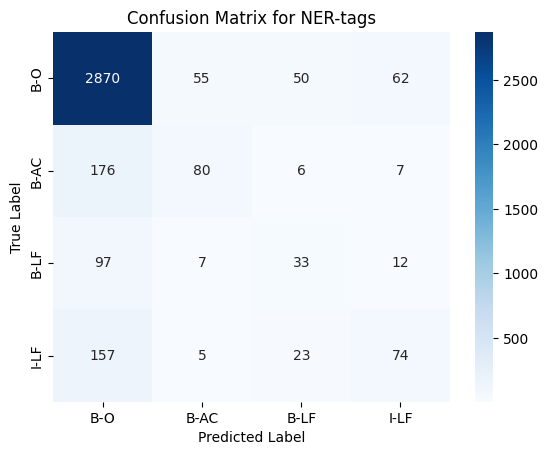

In [13]:
# Training the model
model = LSTM(embedding_dim, hidden_dim, len(word_index), 4)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.9)

for epoch in range(6):
    for i, datapoint in enumerate(train_dataset):
        model.zero_grad()
        sentence_in = encode_sequence(datapoint['tokens'], word_index)
        targets = encode_sequence(encode_label(datapoint['ner_tags']))
        tag_scores = model(sentence_in.unsqueeze(0))
        loss = loss_function(tag_scores.squeeze(0), targets)
        loss.backward()
        optimizer.step()
        # if i == 199:break

    # Model Validation
    model.eval()
    with torch.no_grad():
        for val_datapoint in val_dataset:
            val_inputs = encode_sequence(val_datapoint['tokens'], word_index)
            val_targets = encode_sequence(encode_label(val_datapoint['ner_tags']))
            val_tag_scores = model(val_inputs.unsqueeze(0))
            val_loss = loss_function(val_tag_scores.squeeze(0), val_targets)

    model.train()

# Evaluate on the test set
evaluate(model, test_dataset, word_index)